## copy code from data_genration_detailcode for increse the number of sample and want to see the mean value and standard devation

us shape normalize vanda agadi: (10000, 784)
us shape normalize vanda pachi: (10000, 784)
us shape reshape vanda pachi: (10000, 28, 28, 1)
shape of the x: (784, 2)
Saving training data to u_train.npy...
Saving grid points to grid.npy...
Saving grid points to grid.npy...
Time to save the data: 0.21 seconds
Data saving completed!
Min value after normalization: -1.0
Max value after normalization: 1.0
sample data = (28, 28)


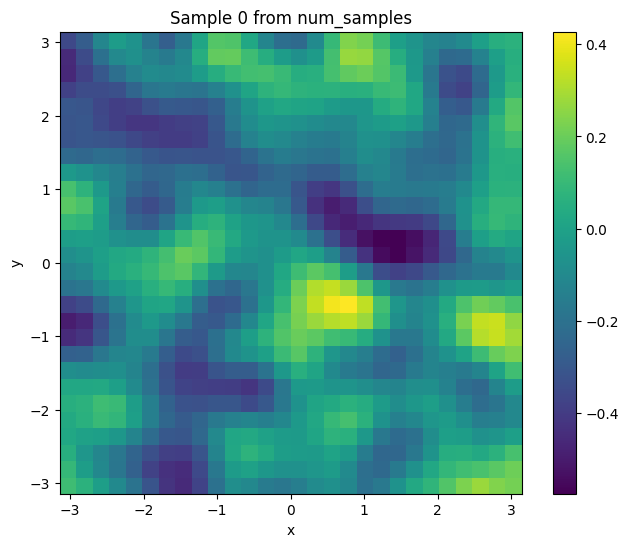

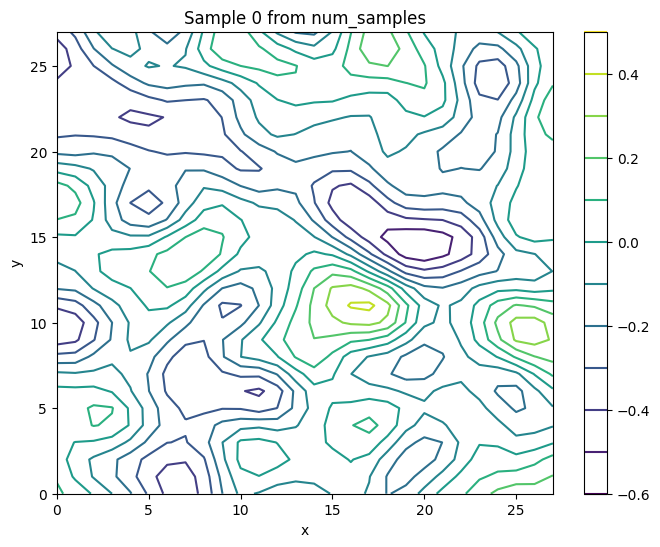

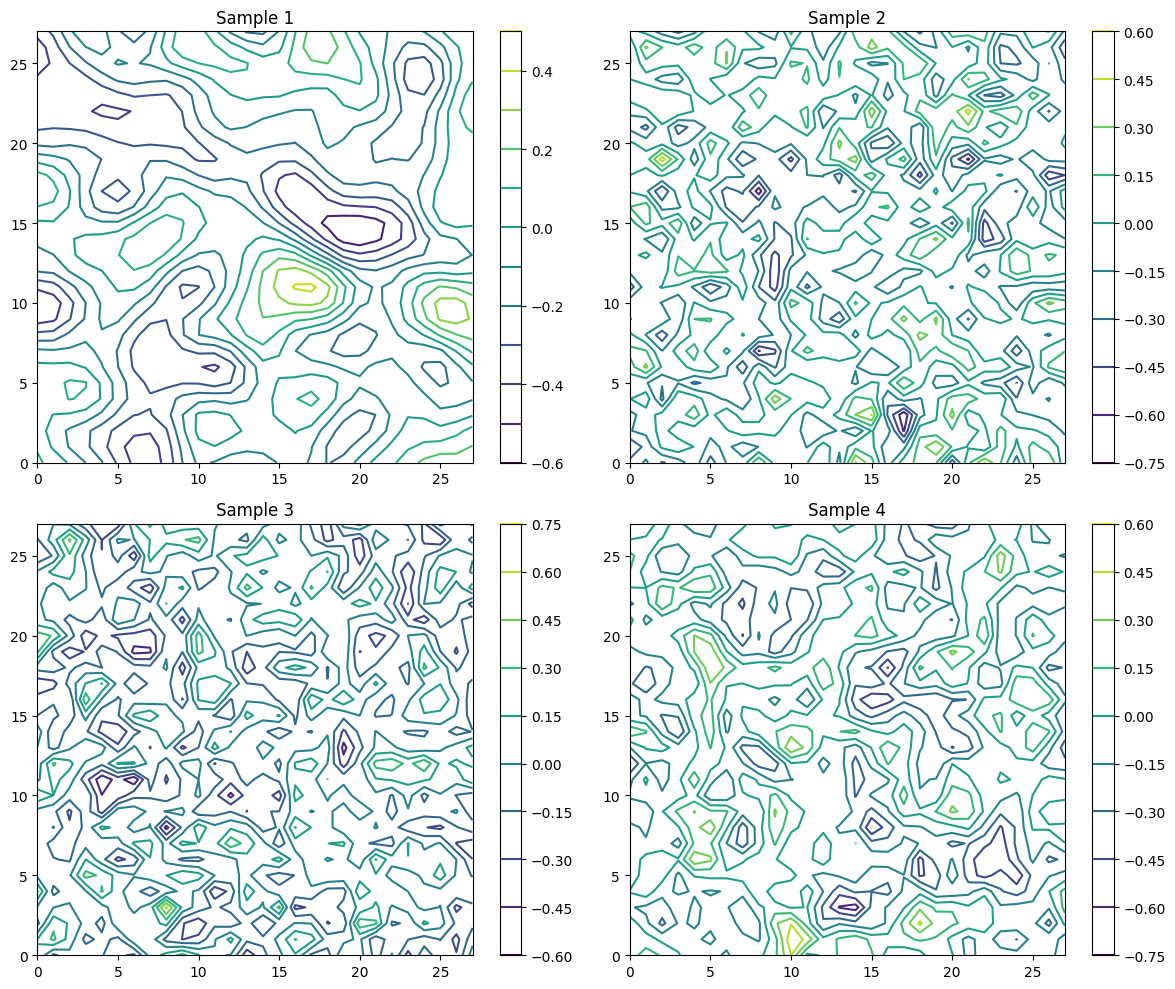

Loaded data shape: (10000, 28, 28, 1)
Grid shape: (784, 2)
Mean of samples: -0.05598192
Std of samples: 0.18643025


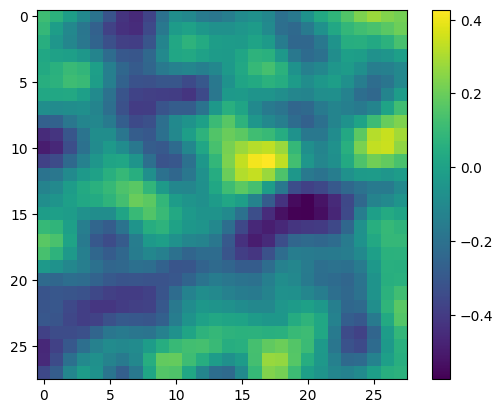

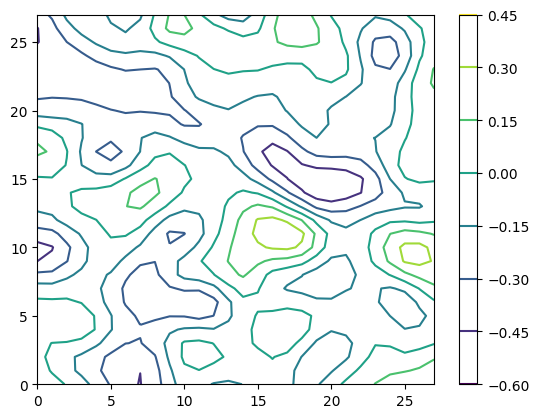

In [8]:
import jax.numpy as jnp
import numpy as np
from jax import random
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os
import time





# Exponential quadratic kernel (Gaussian kernel)
def exp_quadratic(X1, X2, length_scale):
    """Compute the exponential quadratic kernel."""
    dists = cdist(X1, X2, metric="sqeuclidean") #dists is distance and cdists is computed distance between two points 
    # print("Distances min:", jnp.min(dists), "max:", jnp.max(dists))
    kernel = jnp.exp(-dists / (2 * length_scale**2)) # aply the kernel function, wich gives the smoothness of te function
    # print("Kernel min:", jnp.min(kernel), "max:", jnp.max(kernel))
    return kernel


# Gaussian process data generator
def gaussian_process_2d(x, n_grid, n_samples, length_scale_list, u_mean=0.0, key=None):
    """
    Generate 2D Gaussian process samples.
    
    Args:
        x: Tuple of domain limits [x1, x2, y1, y2].
        n_grid: Number of grid points in each dimension.
        n_samples: Number of samples to generate.
        length_scale_list: List of length scales for kernel.
        u_mean: Mean value for Gaussian process.
        key: PRNGKey for randomization.

    Returns:
        X: Grid points.
        ys: Samples generated from the Gaussian process.
    """
    x1, x2, y1, y2 = x
    # Create grid
    xx, yy = jnp.meshgrid(
        jnp.linspace(x1, x2, n_grid), jnp.linspace(y1, y2, n_grid)
    )
    grid_points = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

    if key is None:
        key = random.PRNGKey(42)

    samples = []
    for i in range(n_samples):
        # print(f'generating data {i+1} started out of {n_samples}')
        # Select random length scale
        key, subkey = random.split(key)  # Split the key to ensure randomness
        length_scale = random.choice(subkey, jnp.array(length_scale_list))
        # Compute covariance matrix
        cov = exp_quadratic(grid_points, grid_points, length_scale) # covariance matric is computed, which is used to generate the data, and its gives the relation between the points
        jitter = 1e-3 # this is used to make the matrix positive definite
        cov += jitter * jnp.eye(cov.shape[0])

        # print("Covariance matrix shape:", cov.shape)
        eigenvalues = jnp.linalg.eigvalsh(cov)
        # # print("After adding jitter:")
        # print("Covariance matrix eigenvalues min:", jnp.min(eigenvalues), "max:", jnp.max(eigenvalues))
        # if i == 10:
        #     print("Covariance matrix shape:", cov.shape)
        #     break

        # Generate sample
        sample = random.multivariate_normal(key, u_mean * jnp.ones(grid_points.shape[0]), cov)
        samples.append(sample)
        # print(f'generating data {i+1} done out of {n_samples}')


    return grid_points, jnp.array(samples)


# # Normalize function
# def normalize(data):
#     """Normalize data to the range [-1, 1]."""
#     return 2 * (data - jnp.min(data)) / (jnp.max(data) - jnp.min(data)) - 1


def normalize(data):
    """Normalize data to the range [-1, 1]."""
    min_val = jnp.min(data)
    max_val = jnp.max(data)
    if max_val - min_val == 0:
        return data  # Return unchanged if normalization isn't possible
    return 2 * (data - min_val) / (max_val - min_val) - 1

   


# Data class
class Data:
    def __init__(self, x, n_grid, length_scale_list, num_samples):
        """
        Initialize data generator.

        Args:
            x: Tuple of domain limits [x1, x2, y1, y2].
            n_grid: Resolution of the grid (number of grid points per dimension).
            length_scale_list: List of length scales for the Gaussian process.
            train_num: Number of training samples to generate.
            test_num: Number of testing samples to generate.
        """
        self.x = x
        self.n_grid = n_grid
        self.length_scale_list = length_scale_list
        self.num_samples = num_samples
        # self.test_num = test_num
        self.__init_data()

    def __init_data(self):
        """Initialize training and testing data."""
        self.X, self.num_samples = self.u_data(self.num_samples)
        # _, self.u_test = self.u_data(self.test_num)

    def u_data(self, n_samples=1):
        """
        Generate Gaussian process data.

        Args:
            n_samples: Number of samples to generate.

        Returns:
            X: Grid points.
            us: Corresponding u(x) values at the grid points.
            us: Corresponding u(x) values at the grid points with 3 channels (RGB).
        """
        # Generate data using Gaussian process
        X, us = gaussian_process_2d(
            self.x, self.n_grid, n_samples, self.length_scale_list
        )

        


        # Normalize and reshape the samples
        us = us - jnp.mean(us, axis=0)  # Subtract mean to introduce variance
        print(f'us shape normalize vanda agadi: {us.shape}')

        us = normalize(us)
        print(f'us shape normalize vanda pachi: {us.shape}')
        us = us.reshape(-1, self.n_grid, self.n_grid)  # Reshape to (n_samples, n_grid, n_grid, 1)
        us = jnp.expand_dims(us, axis=-1)
        print(f'us shape reshape vanda pachi: {us.shape}')
        print(f'shape of the x: {X.shape}')

        return X, us



# Example Usage
if __name__ == "__main__":
    # Example: Adjust resolution and domain length
    domain = (-jnp.pi, jnp.pi, -jnp.pi, jnp.pi)  
    resolution = 28  # Number of grid points per dimension
    length_scale_list = [0.1, 0.15, 0.2, 0.3, 0.5]  # Kernel length scales # its indicate the smoothness of the data 
    num_samples = 10000 # Number of training samples
    # test_samples = 5  # Number of testing samples

    # Create data object
    data = Data(domain, resolution, length_scale_list, num_samples)

    # Specify the directory where y want to save the data
    save_dir = './data_generation_checking/'

     # Ensure the directory exists, create it if not
    os.makedirs(save_dir, exist_ok=True)

    # Access generated data
    # print("Training data shape (u_train):", data.u_train.shape)  # (train_samples, resolution, resolution, 1)
    # print("Testing data shape (u_test):", data.u_test.shape)  # (test_samples, resolution, resolution, 1)

    # Start the timer
    start_time = time.time()

    # Save the training and testing data
    print("Saving training data to u_train.npy...")
    np.save(os.path.join(save_dir, "phasefield_data_local2.0_28_10k.npy"), np.array(data.num_samples))

    # print("Saving testing data to u_test.npy...")
    # np.save(os.path.join(save_dir, "u_test.npy"), np.array(data.u_test))

    print("Saving grid points to grid.npy...")
    np.save(os.path.join(save_dir, "grid_local2.0_32_10k.npy"), np.array(data.X))

    # print("Data saving completed!")

    # # Save the grid points (optional, if you want to reconstruct spatial locations)
    print("Saving grid points to grid.npy...")
    # np.save("grid.npy", np.array(data.X))  # Assuming 'data.X' contains the grid points

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time
    print(f"Time to save the data: {elapsed_time:.2f} seconds")

    print("Data saving completed!")


    print("Min value after normalization:", np.min(data.num_samples))
    print("Max value after normalization:", np.max(data.num_samples))




   


# Select a sample to plot
sample_index = 0  # Choose a specific sample (e.g., the first one)
sample = data.num_samples[sample_index, :, :, 0]  # Extract the 2D array for the sample
print(f'sample data = {sample.shape}')
# print(f'sample data = {sample}')

# Plot the sample
plt.figure(figsize=(8, 6))
plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
# plt.contour(sample, levels=10, cmap='viridis')
# plt.colorbar(label="u(x, y)")
plt.title(f"Sample {sample_index} from num_samples")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.figure(figsize=(8, 6))
# plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
plt.contour(sample, levels=10, cmap='viridis')
# plt.colorbar(label="u(x, y)")
plt.title(f"Sample {sample_index} from num_samples")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot multiple samples in a grid
n_plots = 4  # Number of samples to display
plt.figure(figsize=(12, 10))
for i in range(n_plots):
    plt.subplot(2, 2, i+1)
    sample = data.num_samples[i, :, :, 0]
    # plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
    # plt.contour(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
    plt.contour(sample, levels=10, cmap='viridis')
    plt.colorbar()
    plt.title(f"Sample {i+1}")
plt.tight_layout()
plt.show()


loaded_data = np.load(os.path.join(save_dir, "phasefield_data_local2.0_28_10k.npy"))
print("Loaded data shape:", loaded_data.shape)  # Expected: (num_samples, 32, 32, 1)
grid = np.load(os.path.join(save_dir, "grid_local2.0_32_10k.npy"))
print("Grid shape:", grid.shape)  # Expected: (32*32, 2)


print("Mean of samples:", np.mean(loaded_data))
print("Std of samples:", np.std(loaded_data))

# plot the all data together 
loaded_samples = np.load("./data_generation_checking/phasefield_data_local2.0_28_10k.npy")
plt.imshow(loaded_samples[0, :, :, 0], cmap='viridis')
plt.colorbar()
plt.show()

loaded_samples = np.load("./data_generation_checking/phasefield_data_local2.0_28_10k.npy")
plt.contour(loaded_samples[0, :, :, 0], cmap='viridis')
plt.colorbar()
plt.show()

## saving the data same length scale as Onet

us shape normalize vanda agadi: (10000, 784)
us shape normalize vanda pachi: (10000, 784)
us shape reshape vanda pachi: (10000, 28, 28, 1)
shape of the x: (784, 2)
Saving training data to u_train.npy...
Saving grid points to grid.npy...
Time to save the data: 0.05 seconds
Data saving completed!
Min value after normalization: -1.0
Max value after normalization: 1.0
sample data = (28, 28)


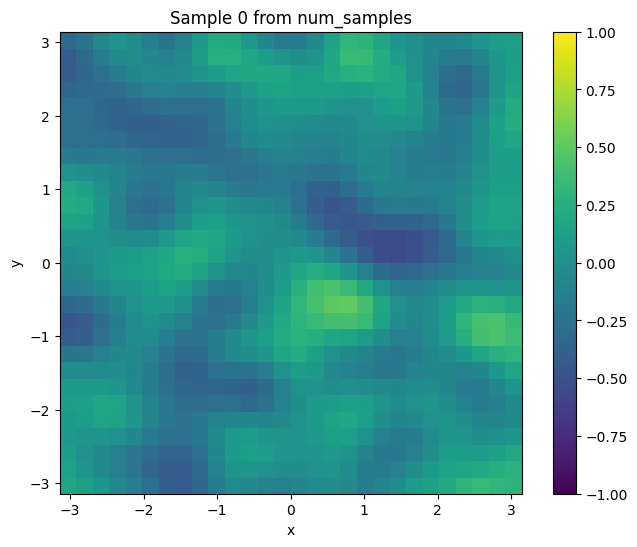

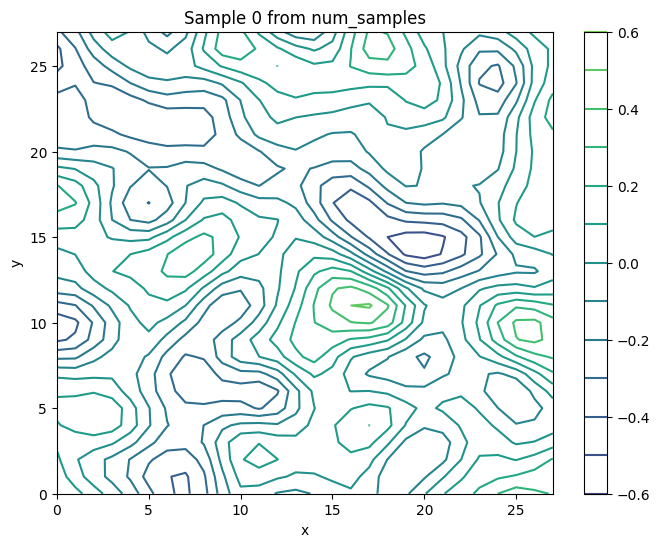

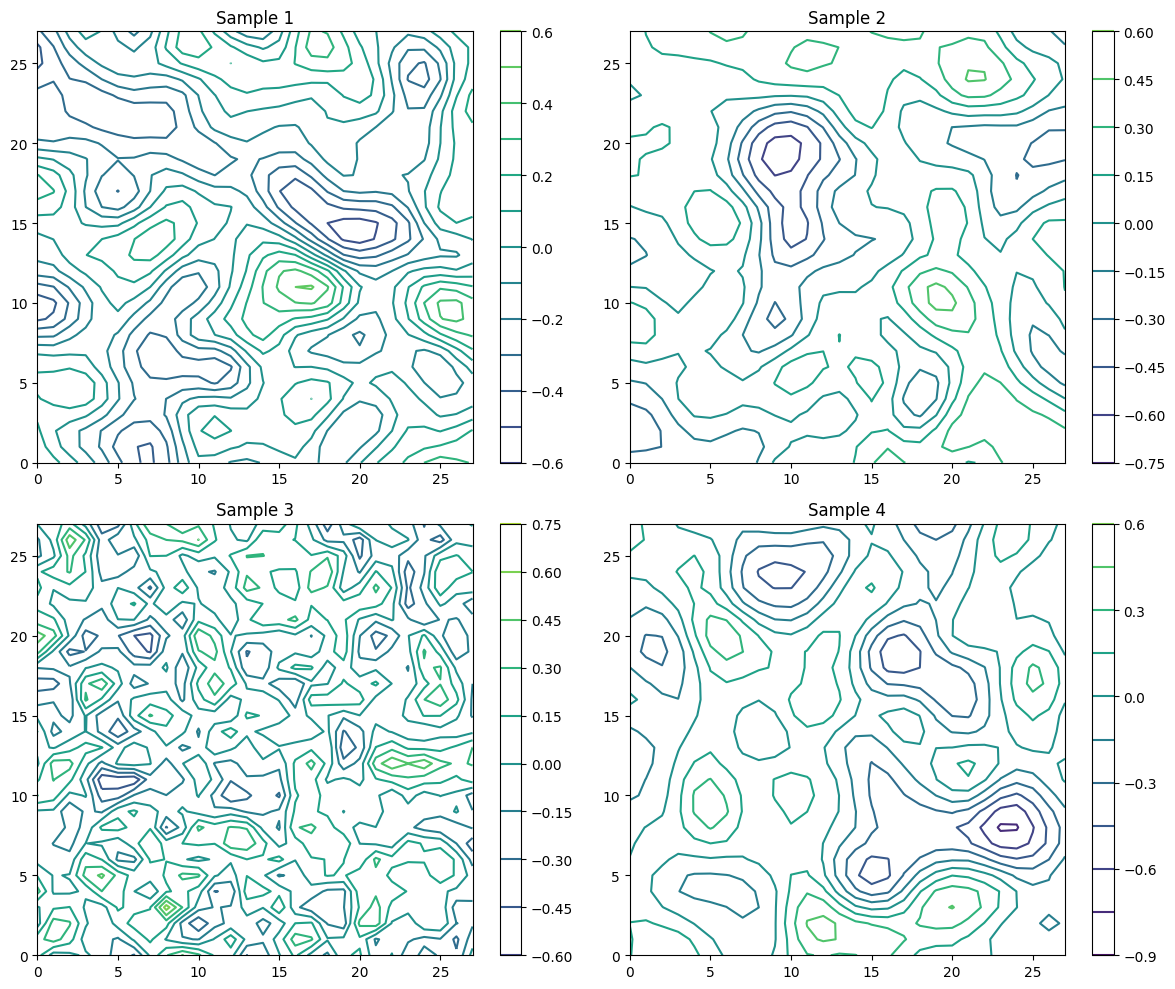

Loaded data shape: (10000, 28, 28, 1)
Grid shape: (784, 2)
Mean of samples: 0.000989157
Std of samples: 0.19772969


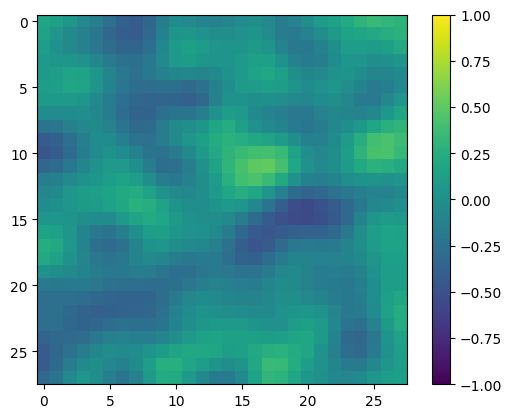

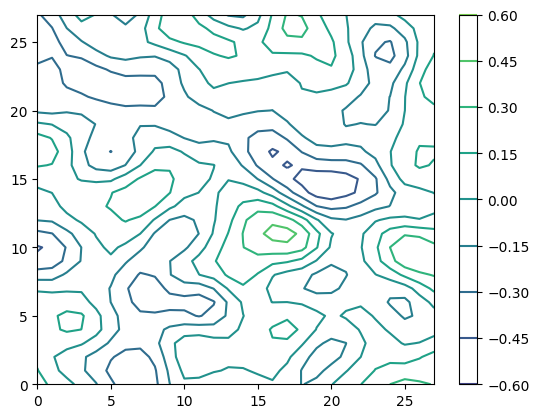

In [7]:
import jax.numpy as jnp
import numpy as np
from jax import random
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os
import time





# Exponential quadratic kernel (Gaussian kernel)
def exp_quadratic(X1, X2, length_scale):
    """Compute the exponential quadratic kernel."""
    dists = cdist(X1, X2, metric="sqeuclidean") #dists is distance and cdists is computed distance between two points 
    # print("Distances min:", jnp.min(dists), "max:", jnp.max(dists))
    kernel = jnp.exp(-dists / (2 * length_scale**2)) # aply the kernel function, wich gives the smoothness of te function
    # print("Kernel min:", jnp.min(kernel), "max:", jnp.max(kernel))
    return kernel


# Gaussian process data generator
def gaussian_process_2d(x, n_grid, n_samples, length_scale_list, u_mean=0.0, key=None):
    """
    Generate 2D Gaussian process samples.
    
    Args:
        x: Tuple of domain limits [x1, x2, y1, y2].
        n_grid: Number of grid points in each dimension.
        n_samples: Number of samples to generate.
        length_scale_list: List of length scales for kernel.
        u_mean: Mean value for Gaussian process.
        key: PRNGKey for randomization.

    Returns:
        X: Grid points.
        ys: Samples generated from the Gaussian process.
    """
    x1, x2, y1, y2 = x
    # Create grid
    xx, yy = jnp.meshgrid(
        jnp.linspace(x1, x2, n_grid), jnp.linspace(y1, y2, n_grid)
    )
    grid_points = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

    if key is None:
        key = random.PRNGKey(42)

    samples = []
    for i in range(n_samples):
        # print(f'generating data {i+1} started out of {n_samples}')
        # Select random length scale
        key, subkey = random.split(key)  # Split the key to ensure randomness
        length_scale = random.choice(subkey, jnp.array(length_scale_list))
        # Compute covariance matrix
        cov = exp_quadratic(grid_points, grid_points, length_scale) # covariance matric is computed, which is used to generate the data, and its gives the relation between the points
        jitter = 1e-3 # this is used to make the matrix positive definite
        cov += jitter * jnp.eye(cov.shape[0])

        # print("Covariance matrix shape:", cov.shape)
        eigenvalues = jnp.linalg.eigvalsh(cov)
        # # print("After adding jitter:")
        # print("Covariance matrix eigenvalues min:", jnp.min(eigenvalues), "max:", jnp.max(eigenvalues))
        # if i == 10:
        #     print("Covariance matrix shape:", cov.shape)
        #     break

        # Generate sample
        sample = random.multivariate_normal(key, u_mean * jnp.ones(grid_points.shape[0]), cov)
        samples.append(sample)
        # print(f'generating data {i+1} done out of {n_samples}')


    return grid_points, jnp.array(samples)


# # Normalize function
# def normalize(data):
#     """Normalize data to the range [-1, 1]."""
#     return 2 * (data - jnp.min(data)) / (jnp.max(data) - jnp.min(data)) - 1


def normalize(data):
    """Normalize data to the range [-1, 1]."""
    min_val = jnp.min(data)
    max_val = jnp.max(data)
    if max_val - min_val == 0:
        return data  # Return unchanged if normalization isn't possible
    return 2 * (data - min_val) / (max_val - min_val) - 1

   


# Data class
class Data:
    def __init__(self, x, n_grid, length_scale_list, num_samples):
        """
        Initialize data generator.

        Args:
            x: Tuple of domain limits [x1, x2, y1, y2].
            n_grid: Resolution of the grid (number of grid points per dimension).
            length_scale_list: List of length scales for the Gaussian process.
            train_num: Number of training samples to generate.
            test_num: Number of testing samples to generate.
        """
        self.x = x
        self.n_grid = n_grid
        self.length_scale_list = length_scale_list
        self.num_samples = num_samples
        # self.test_num = test_num
        self.__init_data()

    def __init_data(self):
        """Initialize training and testing data."""
        self.X, self.num_samples = self.u_data(self.num_samples)
        # _, self.u_test = self.u_data(self.test_num)

    def u_data(self, n_samples=1):
        """
        Generate Gaussian process data.

        Args:
            n_samples: Number of samples to generate.

        Returns:
            X: Grid points.
            us: Corresponding u(x) values at the grid points.
            us: Corresponding u(x) values at the grid points with 3 channels (RGB).
        """
        # Generate data using Gaussian process
        X, us = gaussian_process_2d(
            self.x, self.n_grid, n_samples, self.length_scale_list
        )

        


        # Normalize and reshape the samples
        us = us - jnp.mean(us, axis=0)  # Subtract mean to introduce variance
        print(f'us shape normalize vanda agadi: {us.shape}')

        us = normalize(us)
        print(f'us shape normalize vanda pachi: {us.shape}')
        us = us.reshape(-1, self.n_grid, self.n_grid)  # Reshape to (n_samples, n_grid, n_grid, 1)
        us = jnp.expand_dims(us, axis=-1)
        print(f'us shape reshape vanda pachi: {us.shape}')
        print(f'shape of the x: {X.shape}')

        return X, us



# Example Usage
if __name__ == "__main__":
    # Example: Adjust resolution and domain length
    domain = (-jnp.pi, jnp.pi, -jnp.pi, jnp.pi)  
    resolution = 28  # Number of grid points per dimension
    length_scale_list = [0.2, 0.5]  # Kernel length scales # its indicate the smoothness of the data 
    num_samples = 10000 # Number of training samples
    # test_samples = 5  # Number of testing samples

    # Create data object
    data = Data(domain, resolution, length_scale_list, num_samples)

    # Specify the directory where y want to save the data
    save_dir = './data_generation_checking/'

     # Ensure the directory exists, create it if not
    os.makedirs(save_dir, exist_ok=True)

    # Access generated data
    # print("Training data shape (u_train):", data.u_train.shape)  # (train_samples, resolution, resolution, 1)
    # print("Testing data shape (u_test):", data.u_test.shape)  # (test_samples, resolution, resolution, 1)

    # Start the timer
    start_time = time.time()

    # Save the training and testing data
    print("Saving training data to u_train.npy...")
    np.save(os.path.join(save_dir, "phasefield_data_28x28_Onet_10k.npy"), np.array(data.num_samples))

    # print("Saving testing data to u_test.npy...")
    # np.save(os.path.join(save_dir, "u_test.npy"), np.array(data.u_test))

    print("Saving grid points to grid.npy...")
    np.save(os.path.join(save_dir, "grid_28x28_Onet_10k.npy"), np.array(data.X))

   

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time
    print(f"Time to save the data: {elapsed_time:.2f} seconds")

    print("Data saving completed!")


    print("Min value after normalization:", np.min(data.num_samples))
    print("Max value after normalization:", np.max(data.num_samples))




   


# Select a sample to plot
sample_index = 0  # Choose a specific sample (e.g., the first one)
sample = data.num_samples[sample_index, :, :, 0]  # Extract the 2D array for the sample
print(f'sample data = {sample.shape}')
# print(f'sample data = {sample}')

# Plot the sample
plt.figure(figsize=(8, 6))
plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower',vmin=-1, vmax=1, cmap='viridis')
# plt.contour(sample, levels=10, cmap='viridis')
# plt.colorbar(label="u(x, y)")
plt.title(f"Sample {sample_index} from num_samples")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.figure(figsize=(8, 6))
# plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
plt.contour(sample, levels=10,vmin=-1, vmax=1, cmap='viridis')
# plt.colorbar(label="u(x, y)")
plt.title(f"Sample {sample_index} from num_samples")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot multiple samples in a grid
n_plots = 4  # Number of samples to display
plt.figure(figsize=(12, 10))
for i in range(n_plots):
    plt.subplot(2, 2, i+1)
    sample = data.num_samples[i, :, :, 0]
    # plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
    # plt.contour(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
    plt.contour(sample, levels=10, vmin=-1, vmax=1, cmap='viridis')
    plt.colorbar()
    plt.title(f"Sample {i+1}")
plt.tight_layout()
plt.show()


loaded_data = np.load(os.path.join(save_dir, "phasefield_data_28x28_Onet_10k.npy"))
print("Loaded data shape:", loaded_data.shape)  # Expected: (num_samples, 32, 32, 1)
grid = np.load(os.path.join(save_dir, "grid_local2.0_32_10k.npy"))
print("Grid shape:", grid.shape)  # Expected: (32*32, 2)


print("Mean of samples:", np.mean(loaded_data))
print("Std of samples:", np.std(loaded_data))

# plot the all data together 
loaded_samples = np.load("./data_generation_checking/phasefield_data_28x28_Onet_10k.npy")
plt.imshow(loaded_samples[0, :, :, 0],vmin=-1, vmax=1, cmap='viridis')
plt.colorbar()
plt.show()

loaded_samples = np.load("./data_generation_checking/phasefield_data_28x28_Onet_10k.npy")
plt.contour(loaded_samples[0, :, :, 0], vmin=-1, vmax=1, cmap='viridis')
plt.colorbar()
plt.show()